#### Adult Dataset

In [15]:
from ucimlrepo import fetch_ucirepo 
import json
import pandas as pd
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 

X = adult.data.features 
df_X = pd.DataFrame(X)
# 取1000条数据
df_X = df_X[:1000]
df_X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [16]:
# 制定映射规则，全都转为数值型
# 只取age, education-num, capital-gain, capital-loss, hours-per-week列
input_X = df_X.iloc[:, [0, 4, 10, 11, 12]]
# input_X转为ndarray
input_X = input_X.values
# input_X
y = adult.data.targets
df_y = y['income'].str.strip().str.rstrip('.')
# 制定df_y的映射规则
maps = {'<=50K': 0, 
       '>50K': 1}
input_y = df_y.map(maps).values
input_y = input_y[:1000]

input_X.shape, input_y.shape

((1000, 5), (1000,))

#### 构建邻接矩阵

Text(0.5, 1.0, 'Adult dataset Visualization')

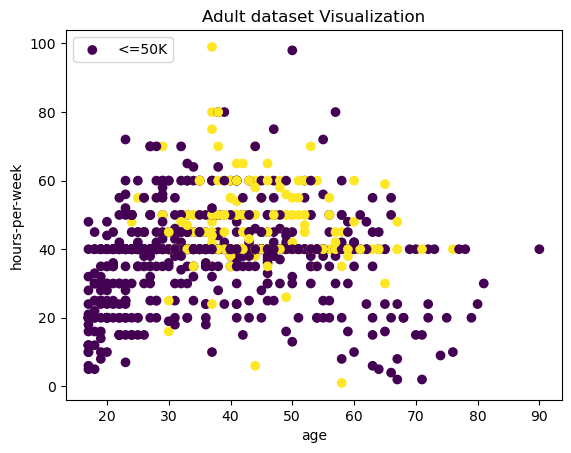

In [17]:
nodes = []
index = 0
from AdultNode import Node, Graph

for df, y in zip(input_X, input_y):
    node = Node(df, y, index)
    nodes.append(node)
    index += 1

%matplotlib inline
from matplotlib import pyplot as plt
# age, education-num, capital-gain, capital-loss, hours-per-week
plt.scatter(input_X[:, 0], input_X[:, 4], c=input_y)
# 图例
plt.legend(['<=50K', '>50K'], loc='upper left')
# 横轴名称：age， 纵轴名称：hours-per-week
plt.xlabel('age')
plt.ylabel('hours-per-week')
# 标题：Adult dataset: Initial Distribution
title = 'Adult dataset Visualization'
plt.title(title)

In [18]:
import numpy as np
DISTANCE = 5
graph = Graph(nodes, distance=DISTANCE)
adjacency_matrix = np.array(graph.get_adjacency_matrix())
print("邻接矩阵：", adjacency_matrix.shape)

#根据邻接矩阵获取所有的二元组，如：[(0, 1), (0, 2), (1, 2)]
edges = graph.get_edges()
print(f"Distance={DISTANCE}, 构建了{len(edges)}条边")

邻接矩阵： (1000, 1000)
Distance=5, 构建了17687条边


#### DeepWalk

In [21]:
import networkx as nx
from util import deepwalk

# Usage
nx = graph.to_nx()
embeddings = deepwalk(nx, walk_length=60, num_walks=200, dim=32)
print(type(embeddings))


<class 'dict'>


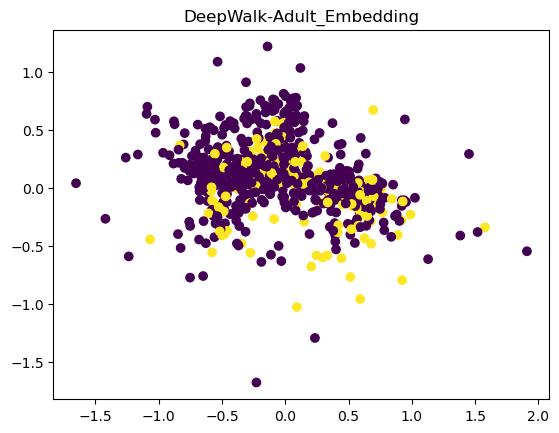

In [22]:
# 取两维做个可视化
# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]

label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("DeepWalk-Adult_Embedding")
# 显示图形
plt.show()

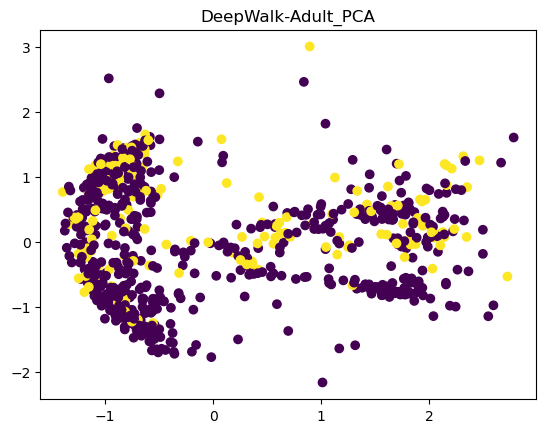

In [28]:
#PCA降维
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("DeepWalk-Adult_PCA")
plt.show()


### GIN

In [ ]:
import os
import csv
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE

from util import Net, GIN, GAT, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)


x = []
with open('./adult.data') as f:
    reader = csv.reader(f)
    for r in reader:
        if len(r) == 15 and int(r[0]) < 90 and 1000 < int(r[10]) and int(r[10]) < 99999:
            x.append([int(r[0]), np.log10(int(r[10]))])

x = np.array(x)
mu = np.mean(x, axis=0, keepdims=True)
std = np.std(x, axis=0, keepdims=True)
x = (x - mu) / std
n = len(x)
m = 500
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = 300
D = pairwise_distances(x) - 1e9 * np.eye(n)
fr = np.arange(n).repeat(K).reshape(-1)
to = np.argsort(D, axis=1)[:, 1:K + 1].reshape(-1)
A = csr_matrix((np.ones(n * K) / K, (fr, to)))

edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)
X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for i in range(100):
    # Note 1: In the original formulation, $g$, i.e., the neural network for the scale function, should be used in reconstruct(K, pr, n, m, fr, to), namely, in the definition of $s$. We factorize $s$ and multiply g after we reconstruct the features. This is mathematically equivalent. We do this to avoid memory overflow due to long backpropagation.
    # Note 2: We roughly standardize n for stability by (n - 3000) / 3000. This does not affect the representational power of GNNs by merging them into the network parameters.
    pr = stationary(A)
    pr = np.maximum(pr, 1e-9)
    rec_orig = reconstruct(K, pr, n, m, fr, to)
    rec_orig = torch.FloatTensor(rec_orig)
    g = net(torch.FloatTensor([(n - 3000) / 3000]))
    rec = rec_orig * (g ** 0.5)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])

    print(n, float(g), float(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_proposed = rec.detach().numpy() @ R.T
loss_proposed = float(dG(torch.FloatTensor(x), rec))


net = GIN(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(100):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(torch.FloatTensor(x), rec))

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(100):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))


c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#eeeeee')
txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

visible = plt.imread('./imgs/visible.png')
visible_ax = fig.add_axes([0.24, 0.77, 0.1, 0.1], anchor='NE', zorder=1)
visible_ax.imshow(visible)
visible_ax.axis('off')

G = nx.DiGraph()
G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
ax = fig.add_subplot(2, 3, 2)
pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw_networkx(G, ax=ax, pos=pos, node_size=1, node_color='#005aff', labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.0002, arrowsize=0.1)
txt = ax.text(0.05, 0.05, 'Input Graph', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
ax.set_rasterization_zorder(3)

ax = fig.add_subplot(2, 3, 3)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'tSNE(X) $d_G = {:.2f}$'.format(loss_tSNE), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 4)
ax.scatter(rec_proposed[:, 0], rec_proposed[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'Proposed $d_G = \\mathbf{' + f'{loss_proposed:.3f}' + '}$', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $d_G = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 6)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $d_G = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_adult.png', bbox_inches='tight', dpi=300)
fig.savefig('imgs/semi_adult.pdf', bbox_inches='tight', dpi=300)
fig.savefig('imgs/semi_adult.svg', bbox_inches='tight', dpi=300)
